# Reinforcement Learning with Function Approximation

In [1]:
!pip install torch==1.2.0 torchvision pyvirtualdisplay matplotlib seaborn pandas numpy pathlib gym
!sudo apt-get install xvfb
!git clone https://github.com/rlgammazero/mvarl_hands_on.git > /dev/null 2>&1
!cd mvarl_hands_on && git pull origin master > /dev/null 2>&1

     |████████████████████████████████| 748.9MB 22kB/s 
ERROR: torchvision 0.4.2 has requirement torch==1.3.1, but you'll have torch 1.2.0 which is incompatible.
  Found existing installation: torch 1.3.1
    Uninstalling torch-1.3.1:
      Successfully uninstalled torch-1.3.1
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 32 not upgraded.
Need to get 783 kB of archives.
After this operation, 2,266 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.3 [783 kB]
Fetched 783 kB in 1s (712 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based front

In [2]:
!apt-get install x11-utils

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  libxxf86dga1
Suggested packages:
  mesa-utils
The following NEW packages will be installed:
  libxxf86dga1 x11-utils
0 upgraded, 2 newly installed, 0 to remove and 32 not upgraded.
Need to get 209 kB of archives.
After this operation, 711 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 libxxf86dga1 amd64 2:1.1.4-1 [13.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/main amd64 x11-utils amd64 7.7+3build1 [196 kB]
Fetched 209 kB in 1s (240 kB/s)
Selecting previously unselected package libxxf86dga1:amd64.
(Reading database ... 145612 files and directories currently installed.)
Preparing to unpack .../libxxf86dga1_2%3a1.1.4-1_amd64.deb ...
Unpacking libxx

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch import optim

from pathlib import Path
import base64

import numpy as np

import gym
from gym.wrappers import Monitor
from pprint import pprint
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from IPython.display import clear_output

import pandas as pd
import itertools
import seaborn as sns

import math

# The following code is will be used to visualize the environments.

def show_video(directory):
    html = []
    for mp4 in Path(directory).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay 
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))
    
display = Display(visible=0, size=(1400, 900))
display.start();

def make_seed(seed):
    np.random.seed(seed=seed)
    torch.manual_seed(seed=seed)

PyTorch is a Python package that provides two high-level features:
- Tensor computation (like NumPy) with strong GPU acceleration
- Deep neural networks built on a tape-based autograd system

At a granular level, PyTorch is a library that consists of the following components:

| Component | Description |
| ---- | --- |
| [**torch**](https://pytorch.org/docs/stable/torch.html) | a Tensor library like NumPy, with strong GPU support |
| [**torch.autograd**](https://pytorch.org/docs/stable/autograd.html) | a tape-based automatic differentiation library that supports all differentiable Tensor operations in torch |
| [**torch.jit**](https://pytorch.org/docs/stable/jit.html) | a compilation stack (TorchScript) to create serializable and optimizable models from PyTorch code  |
| [**torch.nn**](https://pytorch.org/docs/stable/nn.html) | a neural networks library deeply integrated with autograd designed for maximum flexibility |
| [**torch.multiprocessing**](https://pytorch.org/docs/stable/multiprocessing.html) | Python multiprocessing, but with magical memory sharing of torch Tensors across processes. Useful for data loading and Hogwild training |
| [**torch.utils**](https://pytorch.org/docs/stable/data.html) | DataLoader and other utility functions for convenience |


**Tutorials on PyTorch:** https://pytorch.org/tutorials/


## OpenAI gym
We will consider environments provided by OpenAI gym
This library provides a large number of environments to test RL algorithm.

We will focus on the **CartPole-v1** environment in this lab but we encourage you to also test your code on:
* **Acrobot-v1**
* **MountainCar-v0**

| Env Info          	| CartPole-v1 	| Acrobot-v1                	| MountainCar-v0 	|
|-------------------	|-------------	|---------------------------	|----------------	|
| **Observation Space** 	| Box(4)      	| Box(6)                    	| Box(2)         	|
| **Action Space**      	| Discrete(2) 	| Discrete(3)               	| Discrete(3)    	|
| **Rewards**           	| 1 per step  	| -1 if not terminal else 0 	| -1 per step    	|

A gym environment is loaded with the command `env = gym.make(env_id)`. Once the environment is created, you need to reset it with `observation = env.reset()` and then you can interact with it using the method step: `observation, reward, done, info = env.step(action)`.

In [0]:
# We load CartPole-v1
env = gym.make('CartPole-v1')
# We wrap it in order to save our experiment on a file.
env = Monitor(env, "./gym-results", force=True)

In [5]:
done = False
obs = env.reset()
while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
env.close()
show_video("./gym-results")

## REINFORCE

**Q1: Implement the REINFORCE algorithm**

The code is splitted in two parts:
* The Model class defines the architecture of our neural network which takes as input the current state and returns the policy,
* The Agent class is responsible for the training and evaluation procedure. You will need to code the method `optimize_model`.

In [0]:
class Model(nn.Module):
    def __init__(self, dim_observation, n_actions):
        super(Model, self).__init__()
        
        self.n_actions = n_actions
        self.dim_observation = dim_observation
        
        self.net = nn.Sequential(
            nn.Linear(in_features=self.dim_observation, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=8),
            nn.ReLU(),
            nn.Linear(in_features=8, out_features=self.n_actions),
            nn.Softmax(dim=0)
        )
        
    def forward(self, state):
        return self.net(state)
    
    def select_action(self, state):
        action = torch.multinomial(self.forward(state), 1)
        return action

Create the model based on the properties of the MDP you want to solve

In [7]:
env_id = 'CartPole-v1'
env = gym.make(env_id)
model = Model(env.observation_space.shape[0], env.action_space.n)
print(f'The model we created correspond to:\n{model}')

The model we created correspond to:
Model(
  (net): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
    (5): Softmax(dim=0)
  )
)


We provide a base agent that you will need to extend in the next cell with your implementation of `optimize_model`.

In [0]:
class BaseAgent:
    
    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.model = Model(self.env.observation_space.shape[0], self.env.action_space.n)
        self.gamma = config['gamma']
        
        # the optimizer used by PyTorch (Stochastic Gradient, Adagrad, Adam, etc.)
        self.optimizer = torch.optim.Adam(self.model.net.parameters(), lr=config['learning_rate'])
        self.monitor_env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)
    
    # Method to implement
    def _compute_returns(self, rewards):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            The array of rewards of one episode

        Returns
        -------
        array
            The cumulative discounted rewards at each time step
            
        Example
        -------
        for rewards=[1, 2, 3] this method outputs [1 + 2 * gamma + 3 * gamma**2, 2 + 3 * gamma, 3] 
        """
        


        
        raise NotImplementedError
    
    # Method to implement
    def optimize_model(self, n_trajectories):
        """Perform a gradient update using n_trajectories

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expectation card(D) in the formula above
        
        Returns
        -------
        array
            The cumulative discounted rewards of each trajectory
        """
      
        
        
        raise NotImplementedError
    
    def train(self, n_trajectories, n_update):
        """Training method

        Parameters
        ----------
        n_trajectories : int
            The number of trajectories used to approximate the expected gradient
        n_update : int
            The number of gradient updates
            
        """
        
        rewards = []
        for episode in range(n_update):
            rewards.append(self.optimize_model(n_trajectories))
            print(f'Episode {episode + 1}/{n_update}: rewards {round(rewards[-1].mean(), 2)} +/- {round(rewards[-1].std(), 2)}')
        
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards[i]) for i in range(len(rewards))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
    def evaluate(self, render=False):
        """Evaluate the agent on a single trajectory            
        """
        
        observation = self.monitor_env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False
            
        while not done:
            action = self.model.select_action(observation)
            observation, reward, done, info = self.monitor_env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
        
        self.monitor_env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        print(f'Reward: {reward_episode}')

Finally you can implement your agent

In [0]:
class REINFORCE(BaseAgent):
    def  _compute_returns(self, rewards):
        l = len(rewards)
        for i in range(l):
            for j in range(i,l):
                rewards[i] += rewards[j] * gamma**(j-i)
        return rewards
        
    def optimize_model(self, n_trajectories):
      reward_trajectories = [] #it None before
      loss = 0
      for i in range(n_trajectories):
        done = False
        state = torch.tensor(self.env.reset(),dtype=torch.float)
        reward_i = []
        loss_i = []
        while not done:
          action = self.model.select_action(state).item()
          new_state, reward, done, info = self.env.step(action)
          loss_i.append(torch.log(self.model.forward(state)[action]))
          state = torch.tensor(new_state,dtype=torch.float)
          reward_i.append(reward)
          state = torch.tensor(new_state,dtype=torch.float)
        C = self._compute_returns(np.array(reward_i))
        for k in range(len(reward_i)):
          loss += C[k]*loss_i[k]
        reward_trajectories.append(C[0])
      loss = -loss/n_trajectories
      reward_trajectories = np.array(reward_trajectories)
      

        
        # The following lines take care of the gradient descent step for the variable loss
        # that you need to compute.
        
        # Discard previous gradients
      self.optimizer.zero_grad()
      # Compute the gradient 
      loss.backward()
      # Do the gradient descent step
      self.optimizer.step()
      return reward_trajectories
    

In [10]:
env_id = 'CartPole-v1'
learning_rate = 0.01
gamma = 1 
seed = 1235

config = {
    'env_id': env_id,
    'learning_rate': learning_rate,
    'seed': seed,
    'gamma': gamma
}

print("Current config is:")
pprint(config)


Current config is:
{'env_id': 'CartPole-v1', 'gamma': 1, 'learning_rate': 0.01, 'seed': 1235}


Episode 1/50: rewards 17.9 +/- 6.2
Episode 2/50: rewards 24.4 +/- 10.22
Episode 3/50: rewards 22.78 +/- 10.9
Episode 4/50: rewards 24.44 +/- 12.22
Episode 5/50: rewards 24.16 +/- 15.84
Episode 6/50: rewards 25.36 +/- 13.01
Episode 7/50: rewards 25.62 +/- 14.78
Episode 8/50: rewards 25.92 +/- 14.38
Episode 9/50: rewards 27.6 +/- 15.79
Episode 10/50: rewards 26.88 +/- 14.47
Episode 11/50: rewards 29.66 +/- 14.07
Episode 12/50: rewards 30.34 +/- 15.0
Episode 13/50: rewards 27.2 +/- 12.48
Episode 14/50: rewards 28.4 +/- 15.38
Episode 15/50: rewards 29.06 +/- 14.48
Episode 16/50: rewards 39.2 +/- 25.07
Episode 17/50: rewards 37.14 +/- 21.44
Episode 18/50: rewards 34.34 +/- 15.92
Episode 19/50: rewards 34.32 +/- 17.95
Episode 20/50: rewards 41.9 +/- 25.29
Episode 21/50: rewards 34.78 +/- 14.52
Episode 22/50: rewards 44.08 +/- 21.57
Episode 23/50: rewards 43.2 +/- 28.48
Episode 24/50: rewards 49.66 +/- 18.62
Episode 25/50: rewards 47.12 +/- 23.02
Episode 26/50: rewards 54.94 +/- 20.7
Episode 

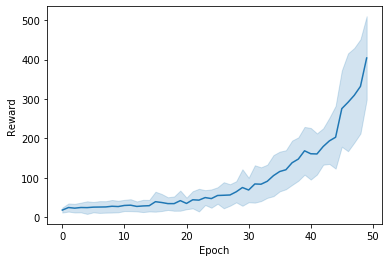

In [11]:
agent = REINFORCE(config)
agent.train(n_trajectories=50, n_update=50)

Evaluate the agent over multiple episodes

In [12]:
agent.evaluate()

Reward: 189.0


## Policy Evaluation as Supervised Learning

**Q2: Implement batched gradient algorithm**

Define network for Q-function (ValueNetwork) and policy (ActorNetwork)


In [0]:
class ValueNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, output_size):
        super(ValueNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out
    
    def predict(self, x):
        return self(x).detach().numpy()[0]

In [0]:
class ActorNetwork(nn.Module):

    def __init__(self, input_size, hidden_size, action_size):
        super(ActorNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)

    def forward(self, x):
        out = F.relu(self.fc1(x))
        out = F.relu(self.fc2(out))
        out = F.softmax(self.fc3(out), dim=-1)
        return out
    
    def select_action(self, x):
        return torch.multinomial(self(x), 1).detach().numpy()

Implement your (batched) gradient algorithm



In [0]:
class EvalAgent:

    def __init__(self, config, policy):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        self.policy = policy

        # Our network
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        
        # optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), 
                                                   lr=config['value_network']['learning_rate'])
    
    def _returns_advantages(self, rewards, dones, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        returns : array
            The cumulative discounted rewards
        """
        batch_size = len(rewards)
        reward = []
        reward_b = []
        one = []
        returns = []
        for i in range(batch_size):
          if not dones[i]:
            reward_b.append(rewards[i])
          else :
            reward_b.append(rewards[i])
            for k in range(len(reward_b)):
              for j in range(k,len(reward_b)):
                reward_b[k] += reward_b[j]* self.gamma**(j-k)
            reward.append(reward_b)
            reward_b = []
            one.append(i) #where the dones==1
        if len(rewards)-1 not in one :
          reward_b.append(next_value)
          for k in range(len(reward_b)):
              for j in range(k,len(reward_b)):
                reward_b[k] += reward_b[j]* self.gamma**(j-k)
          reward.append(reward_b)
        for l in reward :
          for m in l :
            returns.append([m])
        return returns[:batch_size]





        #return NotImplementedError
    
    
    def optimize_model(self, observations, actions, returns): 
        """Perform a gradient update using provided transitions

        Parameters
        ----------
        observations : array
            The observations
        actions : array
            The actions
        returns : array
            The returns from each state

        Returns
        -------
        loss_value: int
            The loss value
        """
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        #returns = torch.tensor(returns[:, None], dtype=torch.float)
        returns = torch.tensor(returns, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        predictions = self.value_network.forward(observations)
        loss_value = F.mse_loss(predictions,returns,reduction='mean')
        self.value_network_optimizer.zero_grad()
        loss_value.backward()
        self.value_network_optimizer.step()
        return loss_value
  
    
    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        mse_test = []

        for epoch in range(epochs):
            # Lets collect one batch
            for i in range(batch_size):
                observations[i] = observation
                values[i] =  self.value_network.predict(torch.tensor(observations[i], dtype=torch.float))
                actions[i] = self.policy.select_action(torch.tensor(observations[i], dtype=torch.float))
                observation,rewards[i],dones[i],info = self.env.step(int(actions[i]))
                # step

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network.predict(torch.tensor(observation,dtype= torch.float))

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns = self._returns_advantages(rewards, dones, next_value)


            # Learning step !
            self.optimize_model(observations, actions, returns)

            # Test it every 50 epochs
            if epoch % 25 == 0 or epoch == epochs - 1:
                L = []
                for _ in range(10):
                    obs_states, y_mc = self.evaluate()
                    y_hat = self.value_network.predict(torch.tensor(obs_states, dtype=torch.float))
                    err = y_mc - y_hat
                    mse = np.mean(err**2)
                    L.append(mse.item())
                mse_test.append(L)
                print(f'Epoch {epoch}/{epochs}: MSE: {np.mean(mse)}')

                observation = self.env.reset()

        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], mse_test[i]) for i in range(len(mse_test))))), columns=['Epoch', 'MSE'])
        sns.lineplot(x="Epoch", y="MSE", data=r, ci='sd');

        print(f'The trainnig was done over a total of {episode_count} episodes')

    def evaluate(self, render=False):
        """Returns the observations and the estimated V-function (using first visit Monte-Carlo)

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network

        Returns
        -------
        states : array
            Observations
        returns : array
            The estimate value function of each state
        """
        env = self.monitor_env if render else self.env
        observation = env.reset()
        states = [observation.copy()]
        rewards= []
        observation = torch.tensor(observation, dtype=torch.float)
        done = False
        steps = 0

        while not done:
            action = self.policy.select_action(observation)
            observation, reward, done, info = env.step(int(action))
            for i in range(steps):
                rewards[i] = rewards[i] + math.pow(self.gamma, steps-i)*reward
            rewards.append(reward)
            if not done:
                states.append(observation.copy())
            observation = torch.tensor(observation, dtype=torch.float)
            steps += 1

        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        states = np.array(states).reshape(-1, self.env.observation_space.shape[0])
        returns = np.array(rewards).reshape(-1,1)
        return states, returns

Define configuration

In [19]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001   
gamma = 0.99
seed = 1

config_td = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate, 'reference': './CartPole_value.pt'}
}

print("Current config_td is:")
pprint(config_td)


Current config_td is:
{'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001, 'reference': './CartPole_value.pt'}}


Create policy

In [20]:
env = gym.make(config_td['env_id'])
policy = ActorNetwork(env.observation_space.shape[0], 16, env.action_space.n)
policy.load_state_dict(torch.load('./mvarl_hands_on/data/CartPole_actor.pt'))
state = torch.tensor(np.array(env.reset(), dtype=np.float32))
print("pi(state) = ", policy.select_action(state))
del env

pi(state) =  [1]


Run agent

Epoch 0/1000: MSE: 7039.383826365838
Epoch 25/1000: MSE: 6975.8844718143455
Epoch 50/1000: MSE: 5129.168067147775
Epoch 75/1000: MSE: 6707.095317431478
Epoch 100/1000: MSE: 6497.494995148703
Epoch 125/1000: MSE: 6192.65464754457
Epoch 150/1000: MSE: 5853.826720806122
Epoch 175/1000: MSE: 5528.7322695146
Epoch 200/1000: MSE: 5173.80398106329
Epoch 225/1000: MSE: 4785.92025874934
Epoch 250/1000: MSE: 4332.003590306414
Epoch 275/1000: MSE: 3901.238299356455
Epoch 300/1000: MSE: 3494.0305661589396
Epoch 325/1000: MSE: 3071.690651033385
Epoch 350/1000: MSE: 2633.6004698855763
Epoch 375/1000: MSE: 2300.1541046249486
Epoch 400/1000: MSE: 2008.6997992963582
Epoch 425/1000: MSE: 1652.0414524578134
Epoch 450/1000: MSE: 1376.799112690997
Epoch 475/1000: MSE: 1185.8244765622421
Epoch 500/1000: MSE: 996.8241058741168
Epoch 525/1000: MSE: 880.2780318192353
Epoch 550/1000: MSE: 802.3224258740523
Epoch 575/1000: MSE: 736.1923694713989
Epoch 600/1000: MSE: 694.7347901562484
Epoch 625/1000: MSE: 663.561

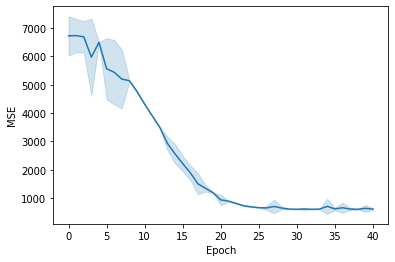

In [21]:
agent = EvalAgent(config=config_td, policy=policy)
agent.training_batch(epochs=1000, batch_size=256) 

## Advantage Actor Critic (A2C)
**Q3: Implement the A2C method**

As usual we provide a structure you can use as starting point.



**Note:** try to reuse previous parts of previous code.



In [0]:
class A2CAgent:

    def __init__(self, config):
        self.config = config
        self.env = gym.make(config['env_id'])
        make_seed(config['seed'])
        self.env.seed(config['seed'])
        self.monitor_env = Monitor(self.env, "./gym-results", force=True, video_callable=lambda episode: True)
        self.gamma = config['gamma']
        
        # Our two networks
        self.value_network = ValueNetwork(self.env.observation_space.shape[0], 16, 1)
        self.actor_network = ActorNetwork(self.env.observation_space.shape[0], 16, self.env.action_space.n)
        
        # Their optimizers
        self.value_network_optimizer = optim.RMSprop(self.value_network.parameters(), lr=config['value_network']['learning_rate'])
        self.actor_network_optimizer = optim.RMSprop(self.actor_network.parameters(), lr=config['actor_network']['learning_rate'])
        
    # Hint: use it during training_batch
    def _returns_advantages(self, rewards, dones, values, next_value):
        """Returns the cumulative discounted rewards at each time step

        Parameters
        ----------
        rewards : array
            An array of shape (batch_size,) containing the rewards given by the env
        dones : array
            An array of shape (batch_size,) containing the done bool indicator given by the env
        values : array
            An array of shape (batch_size,) containing the values given by the value network
        next_value : float
            The value of the next state given by the value network
        
        Returns
        -------
        returns : array
            The cumulative discounted rewards
        advantages : array
            The advantages
        """
        batch_size = len(rewards)
        reward = []
        reward_b = []
        one = []
        returns = []
        advantages = []
        for i in range(batch_size):
          if not dones[i]:
            reward_b.append(rewards[i])
          else :
            reward_b.append(rewards[i])
            for k in range(len(reward_b)):
              for j in range(k,len(reward_b)):
                reward_b[k] += reward_b[j]* self.gamma**(j-k)
            reward.append(reward_b)
            reward_b = []
            one.append(i) #where the dones==1
        if len(rewards)-1 not in one :
          reward_b.append(next_value)
          for k in range(len(reward_b)):
              for j in range(k,len(reward_b)):
                reward_b[k] += reward_b[j]* self.gamma**(j-k)
          reward.append(reward_b)
        for l in reward :
          for m in l :
            returns.append(m)
        returns = returns[:batch_size]
        advantages = returns - values
        return returns,advantages

    def training_batch(self, epochs, batch_size):
        """Perform a training by batch

        Parameters
        ----------
        epochs : int
            Number of epochs
        batch_size : int
            The size of a batch
        """
        episode_count = 0
        actions = np.empty((batch_size,), dtype=np.int)
        dones = np.empty((batch_size,), dtype=np.bool)
        rewards, values = np.empty((2, batch_size), dtype=np.float)
        observations = np.empty((batch_size,) + self.env.observation_space.shape, dtype=np.float)
        observation = self.env.reset()
        rewards_test = []
        for epoch in range(epochs):
            for i in range(batch_size):
                observations[i] = observation
                values[i] =  self.value_network.predict(torch.tensor(observations[i], dtype=torch.float))
                actions[i] = self.actor_network.select_action(torch.tensor(observations[i], dtype=torch.float))
                observation,rewards[i],dones[i],info = self.env.step(int(actions[i]))

                # step

                if dones[i]:
                    observation = self.env.reset()

            # If our epiosde didn't end on the last step we need to compute the value for the last state
            if dones[-1]:
                next_value = 0
            else:
                next_value = self.value_network.predict(torch.tensor(observation,dtype= torch.float))

            # Update episode_count
            episode_count += sum(dones)

            # Compute returns
            returns,advantages = self._returns_advantages(rewards, dones, values, next_value)

            # Learning step !
            self.optimize_model(observations, actions, returns, advantages,dones)

            # Test it every 50 epochs
            if epoch % 50 == 0 or epoch == epochs - 1:
                rewards_test.append(np.array([self.evaluate() for _ in range(50)]))
                print(f'Epoch {epoch}/{epochs}: Mean rewards: {round(rewards_test[-1].mean(), 2)}, Std: {round(rewards_test[-1].std(), 2)}')

                # Early stopping
                if rewards_test[-1].mean() > 490 and epoch != epochs -1:
                    print('Early stopping !')
                    break
                observation = self.env.reset()
                    
        # Plotting
        r = pd.DataFrame((itertools.chain(*(itertools.product([i], rewards_test[i]) for i in range(len(rewards_test))))), columns=['Epoch', 'Reward'])
        sns.lineplot(x="Epoch", y="Reward", data=r, ci='sd');
        
        print(f'The trainnig was done over a total of {episode_count} episodes')

    def optimize_model(self, observations, actions, returns, advantages,dones):
        n_trajectories = np.sum(dones)
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        #returns = torch.tensor(returns[:, None], dtype=torch.float)
        returns = torch.tensor(returns, dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        actions = F.one_hot(torch.tensor(actions), self.env.action_space.n)
        returns = torch.tensor(returns, dtype=torch.float)
        advantages = torch.tensor(advantages, dtype=torch.float)
        observations = torch.tensor(observations, dtype=torch.float)
        predictions_values = self.value_network.forward(observations)
        loss_values = F.mse_loss(predictions_values,returns,reduction='mean')
        predictions_actions = self.actor_network.select_action(observations)
        loss_actor = torch.dot(torch.log(torch.tensor(predictions_actions,dtype=torch.float)).flatten(), advantages.flatten())/n_trajectories
        entropy = torch.dot(torch.log(torch.tensor(predictions_actions,dtype=torch.float)).flatten(), torch.tensor(predictions_actions,dtype=torch.float).flatten())
        loss = loss_actor + loss_values + 0.001*entropy
        self.value_network_optimizer.zero_grad()
        self.actor_network_optimizer.zero_grad()
        loss.backward()
        self.value_network_optimizer.step()
        self.actor_network_optimizer.step()

        return loss


    def evaluate(self, render=False):
        env = self.monitor_env if render else self.env
        observation = env.reset()
        observation = torch.tensor(observation, dtype=torch.float)
        reward_episode = 0
        done = False

        while not done:
            policy = self.actor_network(observation)
            action = torch.multinomial(policy, 1)
            observation, reward, done, info = env.step(int(action))
            observation = torch.tensor(observation, dtype=torch.float)
            reward_episode += reward
            
        env.close()
        if render:
            show_video("./gym-results")
            print(f'Reward: {reward_episode}')
        return reward_episode

Create configuration for A2C

In [38]:
env_id = 'CartPole-v1'
value_learning_rate = 0.001
actor_learning_rate = 0.001
gamma = 0.99
entropy = 1
seed = 1

config_a2c = {
    'env_id': env_id,
    'gamma': gamma,
    'seed': seed,
    'value_network': {'learning_rate': value_learning_rate},
    'actor_network': {'learning_rate': actor_learning_rate},
    'entropy': entropy
}

print("Current config_a2c is:")
pprint(config_a2c)

Current config_a2c is:
{'actor_network': {'learning_rate': 0.001},
 'entropy': 1,
 'env_id': 'CartPole-v1',
 'gamma': 0.99,
 'seed': 1,
 'value_network': {'learning_rate': 0.001}}


Run the learning agent

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:139: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:140: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:141: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:142: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

Epoch 0/1000: Mean rewards: 21.5, Std: 11.02
Epoch 50/1000: Mean rewards: 21.68, Std: 10.48
Epoch 100/1000: Mean rewards: 21.3, Std: 10.99
Epoch 150/1000: Mean rewards: 25.18, Std: 13.01
Epoch 200/1000: Mean rewards: 24.16, Std: 14.66
Epoch 250/1000: Mean rewards: 24.22, Std: 10.24
Epoch 300/1000: Mean rewards: 20.4, Std: 7.5
Epoch 350/1000: Mean rewards: 20.28, Std: 9.36
Epoch 400/1000: Mean rewards: 24.22, Std: 14.62
Epoch 450/1000: Mean rewards: 21.38, Std: 10.99
Epoch 500/1000: Mean rewards: 22.12, Std: 11.26
Epoch 550/1000: Mean rewards: 20.96, Std: 9.97
Epoch 600/1000: Mean rewards: 23.8, Std: 13.28
Epoch 650/1000: Mean rewards: 19.16, Std: 8.06
Epoch 700/1000: Mean rewards: 21.58, Std: 10.21
Epoch 750/1000: Mean rewards: 20.56, Std: 9.13
Epoch 800/1000: Mean rewards: 18.42, Std: 8.25
Epoch 850/1000: Mean rewards: 21.58, Std: 9.74
Epoch 900/1000: Mean rewards: 24.94, Std: 13.35
Epoch 950/1000: Mean rewards: 20.18, Std: 10.04
Epoch 999/1000: Mean rewards: 20.52, Std: 7.41
The trai

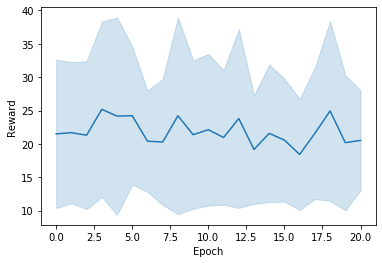

In [39]:
agent = A2CAgent(config_a2c)
rewards = agent.training_batch(1000, 256)

Evaluate the agent over multiple episodes

In [40]:
agent.evaluate()

21.0